# Best Hospitals of Different Specialty

<font color='coral'>
- Scrape the data from the <a href='https://health.usnews.com/best-hospitals/search'>U.S.News Health</a>.
- Get the top 50 hospitals' detailed data.
  - Name
  - Specilty
  - Score
  - Zipcode
  - City
  - State

### Packages Requirement
**Selenium**
- To install selenium, run in terminal:
```
pip install selenium
```

- Since I use **chrome**, I have to download <a href='http://chromedriver.chromium.org/'>Chrome Driver</a> first.
Then move it to a safe location
```
mv [location]/chromedriver /usr/local/bin/chromedriver
```

**BeautifulSoup**
- To install, run in terminal or run following cells:
```
pip install beautifulsoup4
```


In [ ]:
!pip install beautifulsoup4
!pip install selenium
!pip install pandas
!pip install imageio

In [1]:
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from html.parser import HTMLParser
import pandas as pd
from matplotlib.pyplot import imshow
import imageio

In [2]:
driver = webdriver.Chrome(executable_path='/usr/local/bin/chromedriver')
url = 'https://health.usnews.com/best-hospitals/search'
driver.get(url)

### Screenshot
- Take a screenshot.
- There are `17` fields under `Specialty`.

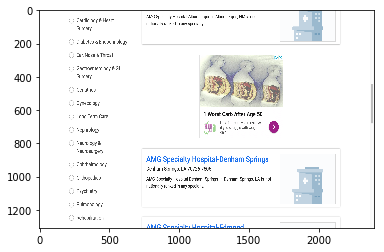

In [3]:
driver.execute_script("window.scrollTo(0, 1150);")
sc = driver.save_screenshot('images/screen.png')
content_image = imageio.imread('images/screen.png')
imshow(content_image,interpolation='nearest', aspect='auto')

## Configure URL

- Now that we want to get all the area under the specilty.
- All the `,` should be removed
- All the `&` becomes `and`.
- All the space characters are replaced by `-`.

In [4]:
data = BeautifulSoup(driver.page_source, "html.parser")
fields = list(map(lambda x: x.replace('\n','').strip(), list(map(lambda x: x.text, data.find_all("label")))))
fields = list(map(lambda x: '-'.join(x.replace(',',' ').replace('&','and').split()), fields))
fields = fields[fields.index('Cancer'):(fields.index('Urology')+1)]
fields[fields.index('Geriatrics')] = 'geriatric-care'
fields

['Cancer',
 'Cardiology-and-Heart-Surgery',
 'Diabetes-and-Endocrinology',
 'Ear-Nose-and-Throat',
 'Gastroenterology-and-GI-Surgery',
 'geriatric-care',
 'Gynecology',
 'Long-Term-Care',
 'Nephrology',
 'Neurology-and-Neurosurgery',
 'Ophthalmology',
 'Orthopedics',
 'Psychiatry',
 'Pulmonology',
 'Rehabilitation',
 'Rheumatology',
 'Urology']


## Data Cleaning Functions

<font color='coral'>


- Using the `Specialty` area
- Click `Load More` to get top 20 data.

### Names
- First of all we get the names.

In [7]:
def get_name(data1):
    name = list(map(lambda x: x.text.replace('\n','').strip(), data1.find_all('a',{'class':'search-result-link'})))
    return name

### The Scores 
- We now get the scores of each hospital.
- Max score is 100.

In [9]:
def get_score(data1):
    score = list(map(lambda x: x.replace('/100',''), [x.text for x in data1.find_all('dt') if len(str(x)) <= 18]))
    return score

### The address
- We want to get the city, state and zipcode

In [10]:
def get_address(data1):
    block_tight = [x for x in data1.find_all('div',{'class':'block-tight'})[2:] if '<div class="block-tight">' in str(x)]
    address = list(map(lambda x: x.text.replace('\n','').strip(), block_tight))
    zipcode = list(map(lambda x: x.split()[-1], address))
    address = [address[i].replace(zipcode[i],'').split('|')[-1].strip() for i in range(len(address))]
    city = list(map(lambda x: x.split(',')[0],address))
    state =  list(map(lambda x: x.split(',')[1].strip(),address))
    return zipcode, city, state

<font color='blue'>
    
## Scrape Data

In [11]:
def SearchUSNewsHealth(specialty):
    driver = webdriver.Chrome(executable_path='/usr/local/bin/chromedriver')
    best_hospitals = []
    url = 'https://health.usnews.com/best-hospitals/rankings/'+specialty
    driver.get(url)
    ## Scroll down once to get 10 more
    driver.find_element_by_css_selector("#search-app-matches-more-button-region > div > a").click()
    ## Sleep 2 seconds for the data to load completely
    time.sleep(2)
    data1 = BeautifulSoup(driver.page_source, "html.parser")
    ## The name
    name = get_name(data1)
    ## The score
    score = get_score(data1)
    ## The address
    zipcode, city, state = get_address(data1)
    ## return the list
    for i in range(len(name)):
        best_hospitals.append({
            'specialty': ' '.join(specialty.split('-')),
            'name': name[i],
            'zipcode':zipcode[i],
            'city': city[i],
            'state': state[i],
            'score': score[i]
        })
    driver.quit()
    return best_hospitals

- We exclude `Long term care` since it is not being scored.

In [12]:
bests = []
fields.remove('Long-Term-Care')
for specialty in fields:
    bests += SearchUSNewsHealth(specialty)
hospitals = pd.DataFrame(bests)

In [13]:
hospitals

,city,name,score,specialty,state,zipcode
0,Houston,University of Texas MD Anderson Cancer Center,100.0,Cancer,TX,77030-4000
1,New York,Memorial Sloan Kettering Cancer Center,97.4,Cancer,NY,10065-6007
2,Rochester,Mayo Clinic,91.8,Cancer,MN,55902-1906
3,Boston,Dana-Farber/Brigham and Women's Cancer Center,84.4,Cancer,MA,02215-5418
4,Seattle,Seattle Cancer Alliance/University of Washingt...,76.5,Cancer,WA,98109-4405
5,Baltimore,Johns Hopkins Hospital,75.9,Cancer,MD,21205-1832
6,Cleveland,Cleveland Clinic,75.0,Cancer,OH,44195-5108
7,Philadelphia,Hospitals of the University of Pennsylvania-Pe...,75.0,Cancer,PA,19104-4206
8,Tampa,Moffitt Cancer Center and Research Institute,74.9,Cancer,FL,33612-9497
9,San Francisco,UCSF Medical Center,73.3,Cancer,CA,94143-0296


In [14]:
hospitals.to_csv('best_hospital.csv')